This notebook aims to create a all in one synthetic data function that can remove outliers, add noise and avoid duplicating the real data.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


# Generate some mock real data

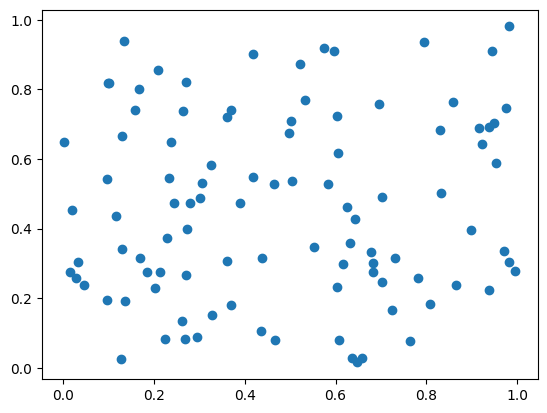

In [2]:

real_data = np.random.rand(100, 2)
real_data = pd.DataFrame(real_data, columns=['x', 'y'])
# plot real data
plt.scatter(real_data['x'], real_data['y'], label='real data')

# First simple iteration

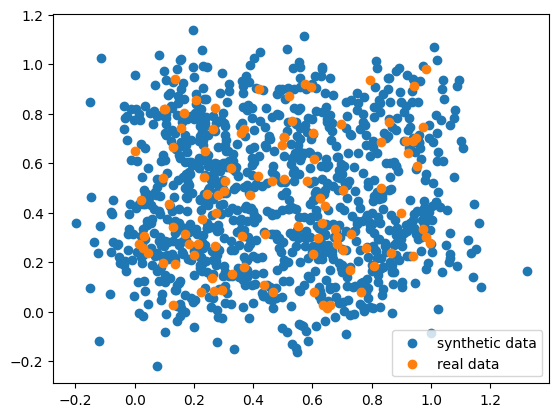

In [51]:
def generate_synthetic_data(
    real_data,
    n_samples=1000,
    fidelity=0.1,
):
    # generate synthetic data
    synthetic_data = real_data.sample(n_samples, replace=True)
    for col in synthetic_data.columns:
        noise = np.random.normal(0, fidelity, n_samples)
        synthetic_data[col] += noise
    return synthetic_data
example_data = generate_synthetic_data(real_data)
# plot synthetic data
plt.scatter(example_data['x'], example_data['y'], label='synthetic data')
plt.scatter(real_data['x'], real_data['y'], label='real data')
plt.legend()

# Simple outlier identifier

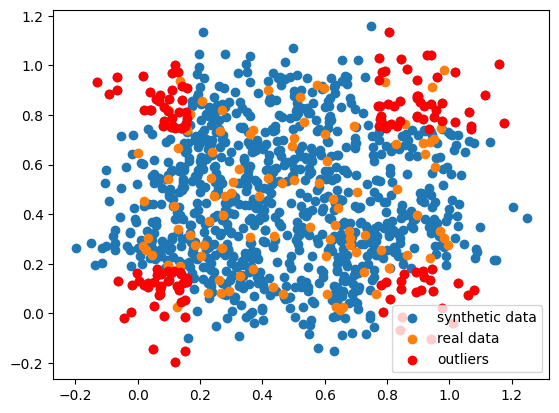

In [15]:
# Circle all outliers in the synthetic data
def identify_outliers(data):
    # calculate the mean and standard deviation of the data
    mean = data.mean()
    std = data.std()
    # calculate the z-score of the data
    z_score = (data - mean) / std
    # identify the outliers
    outliers = z_score.abs() > 1
    return outliers
example_outliers = identify_outliers(example_data)
# plot outliers
plt.scatter(example_data['x'], example_data['y'], label='synthetic data')
plt.scatter(real_data['x'], real_data['y'], label='real data')
plt.scatter(example_data[example_outliers]['x'], example_data[example_outliers]['y'], label='outliers', color='red')
plt.legend()

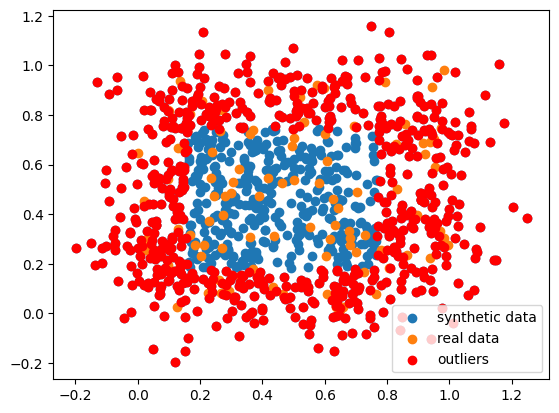

In [37]:
# Circle all outliers in the synthetic data per variable
def identify_outliers_per_variable(data, distance=1):
    # calculate the mean and standard deviation of the data
    outliers_full = pd.Series(False, index=data.index)
    for col in reversed(data.columns):
        mean = data[col].mean()
        std = data[col].std()
        # calculate the z-score of the data
        z_score = (data[col] - mean) / std
        # identify the outliers
        outliers = z_score.abs() > distance
        outliers_full = outliers_full | outliers
    return outliers_full
example_outliers = identify_outliers_per_variable(example_data)


# plot outliers
plt.scatter(example_data['x'], example_data['y'], label='synthetic data')
plt.scatter(real_data['x'], real_data['y'], label='real data')
plt.scatter(example_data[example_outliers]['x'], example_data[example_outliers]['y'], label='outliers', color='red')
plt.legend()

# Remove points that are near the real data

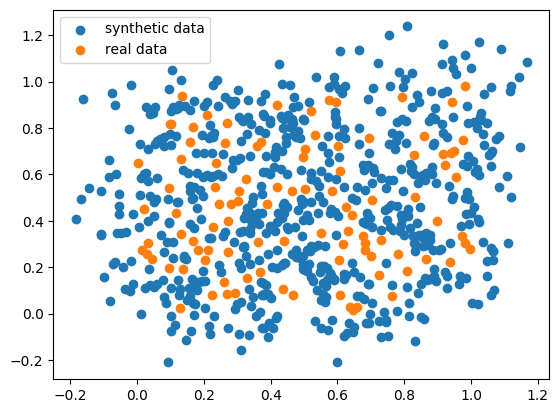

In [67]:
# Remove points that are close to real points
def remove_close_points(real_data, synthetic_data, distance=0.04):
    # calculate the distance between the real and synthetic data
    distance_matrix = np.linalg.norm(real_data.values[:, None] - synthetic_data.values, axis=2)
    # identify the points that are close to the real data
    close_points = distance_matrix.min(axis=0) < distance
    synthetic_data[close_points] = np.nan
    return synthetic_data
example_data = generate_synthetic_data(real_data)
example_data = remove_close_points(real_data, example_data)
# plot synthetic data
plt.scatter(example_data['x'], example_data['y'], label='synthetic data')
plt.scatter(real_data['x'], real_data['y'], label='real data')
plt.legend()

# Combine all into single function

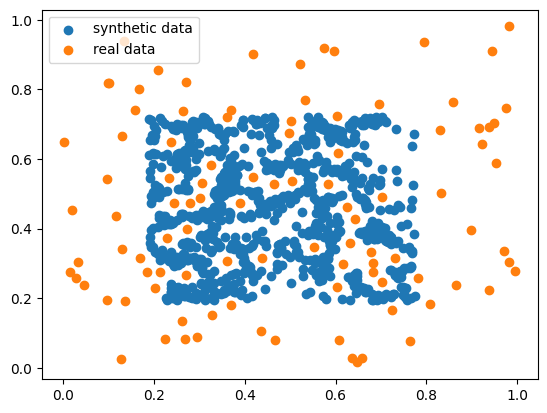

In [82]:
def generate_synthetic_data_advanced(
    real_data,
    n_samples=8000,
    fidelity=0.03,
    outlier_distance=1,
    closest_distance_clip=0.035,
):
    # generate synthetic data
    synthetic_data = generate_synthetic_data(real_data, n_samples=n_samples, fidelity=fidelity)
    outliers = identify_outliers_per_variable(synthetic_data, distance=outlier_distance)
    synthetic_data[outliers] = np.nan
    synthetic_data = remove_close_points(real_data, synthetic_data, distance=closest_distance_clip)
    return synthetic_data
example_data = generate_synthetic_data_advanced(real_data)
# plot synthetic data
plt.scatter(example_data['x'], example_data['y'], label='synthetic data')
plt.scatter(real_data['x'], real_data['y'], label='real data')
plt.legend()
